# Washington DC Biking data | Hourly Bike Count Prediction
MBD O-1-5

### Notebook preperation

In [39]:
# Imports
%matplotlib inline


from My_Functions import * 
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score,roc_curve
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict,validation_curve
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler,PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator , MultipleLocator
##from matplotlib import XAxis
from gplearn.genetic import SymbolicRegressor

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression,LinearRegression, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split , TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from matplotlib.gridspec import GridSpec
import plotly.tools as tls
import plotly
plotly.tools.set_credentials_file(username='Furqan92', api_key='22DfVN5rFRg79OYygN5h')
import plotly.plotly as py
from sklearn.decomposition import PCA
from pandas import DataFrame 
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore')
random_seed = 1234

In [11]:
# To automatically reload the function file 
%load_ext autoreload
%aimport My_Functions
%run My_Functions.py
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

In [12]:
# Data Import
daily_raw_data = pd.read_csv('day.csv')
hourly_raw_data=pd.read_csv('hour.csv')

In [13]:
daily_raw_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [14]:
daily_raw_data.isnull().any()

instant       False
dteday        False
season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
casual        False
registered    False
cnt           False
dtype: bool

In [15]:
daily_raw_data.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

### DAILY DATA visuals

In [43]:
mpl_fig =plt.figure(figsize=(20,10))
plt.plot(daily_raw_data['dteday'],daily_raw_data['cnt'])
plt.plot(daily_raw_data['dteday'],daily_raw_data['registered'])
plt.plot(daily_raw_data['dteday'],daily_raw_data['casual'])
plt.legend(['cnt', 'registered', 'casual'], loc='upper left')
mpl_fig.gca().xaxis.set_major_locator(plt.MultipleLocator(10)) 

plotly_fig=tls.mpl_to_plotly(mpl_fig)
plotly_fig['layout']['title'] = 'Daily Bike Users'
plotly_fig['layout']['xaxis1']['showgrid'] = True
plotly_fig['layout']['xaxis1']['autorange'] = True
plotly_fig['layout']['yaxis1']['showgrid'] = True
plotly_fig['layout']['yaxis1']['autorange'] = True

py.iplot(plotly_fig,filename='Daily_Bike_Users')

# xmajorLocator = matplotlib.ticker.FixedLocator(locs=xticks) 
# xmajorFormatter = matplotlib.ticker.ScalarFormatter()
# plt.gca().xaxis.set_major_locator( xmajorLocator )
# plt.gca().xaxis.set_major_formatter( xmajorFormatter )
# plt.gca().xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# # 

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5),
#                                tight_layout=True, sharey=True)

# arts = stack_hist(ax1, dict_data, color_cycle + hatch_cycle,
#                   hist_func=hist_func)

# arts = stack_hist(ax2, dict_data, color_cycle + hatch_cycle,
#                   hist_func=hist_func, labels=['set 0', 'set 3'])
# ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
# ax1.set_xlabel('counts')
# ax1.set_ylabel('x')
# ax2.set_ylabel('x')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Furqan92/0 or inside your plot.ly account where it is named 'Daily_Bike_Users'


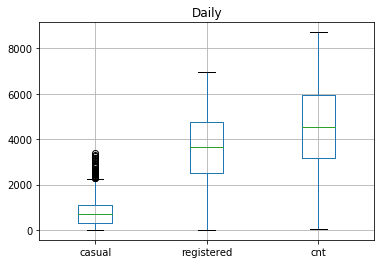

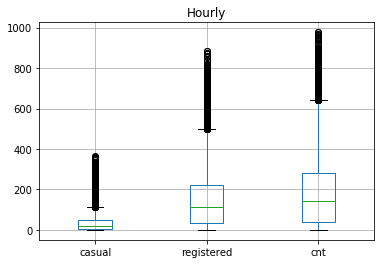

In [13]:
daily_raw_data.boxplot(column = ['casual','registered','cnt'])
plt.title('Daily')
plt.show()
hourly_raw_data.boxplot(column = ['casual','registered','cnt'])
plt.title('Hourly')
plt.show()

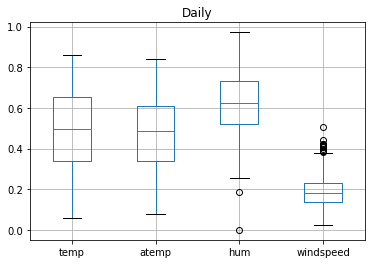

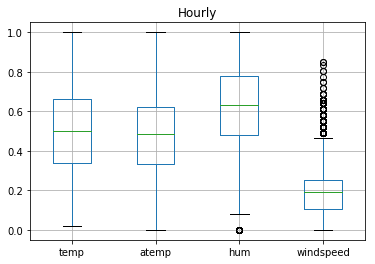

In [14]:
daily_raw_data.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Daily')
plt.show()
hourly_raw_data.boxplot(column = ['temp','atemp','hum','windspeed'])
plt.title('Hourly')
plt.show()

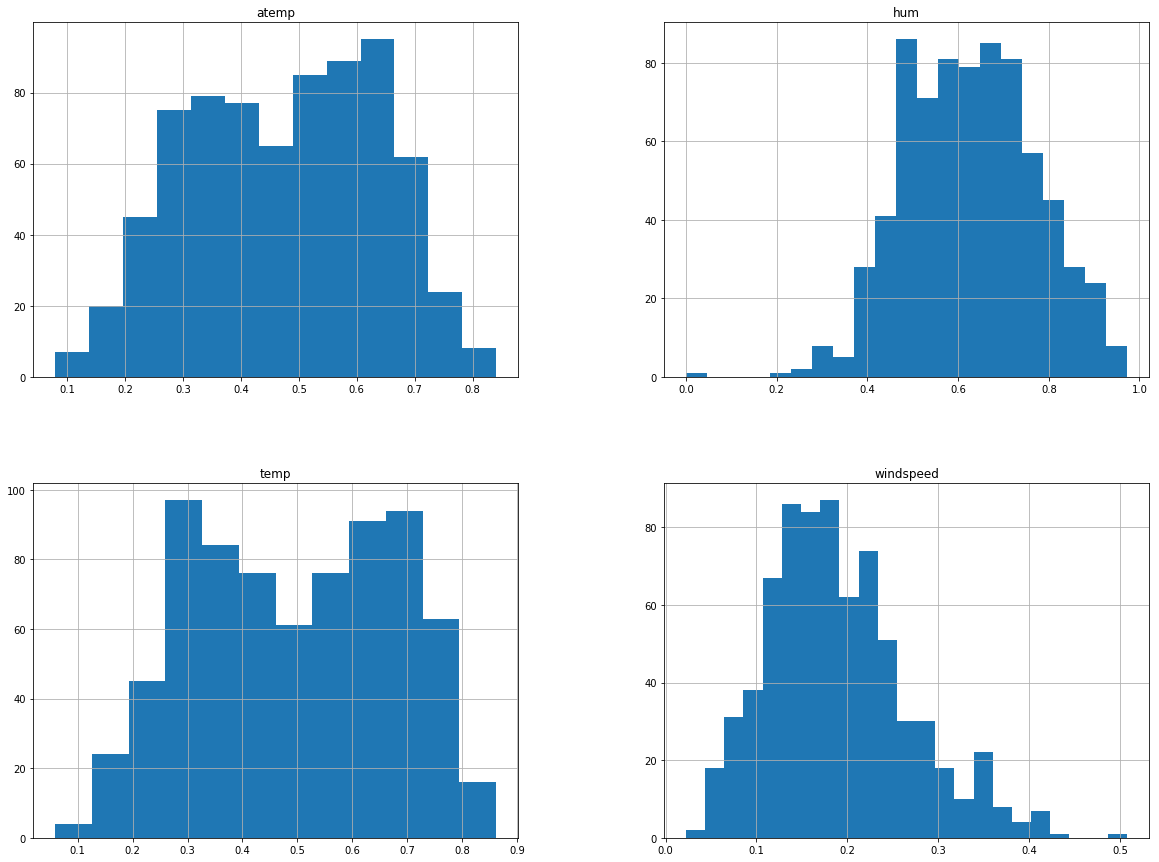

In [15]:
num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
daily_raw_data[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

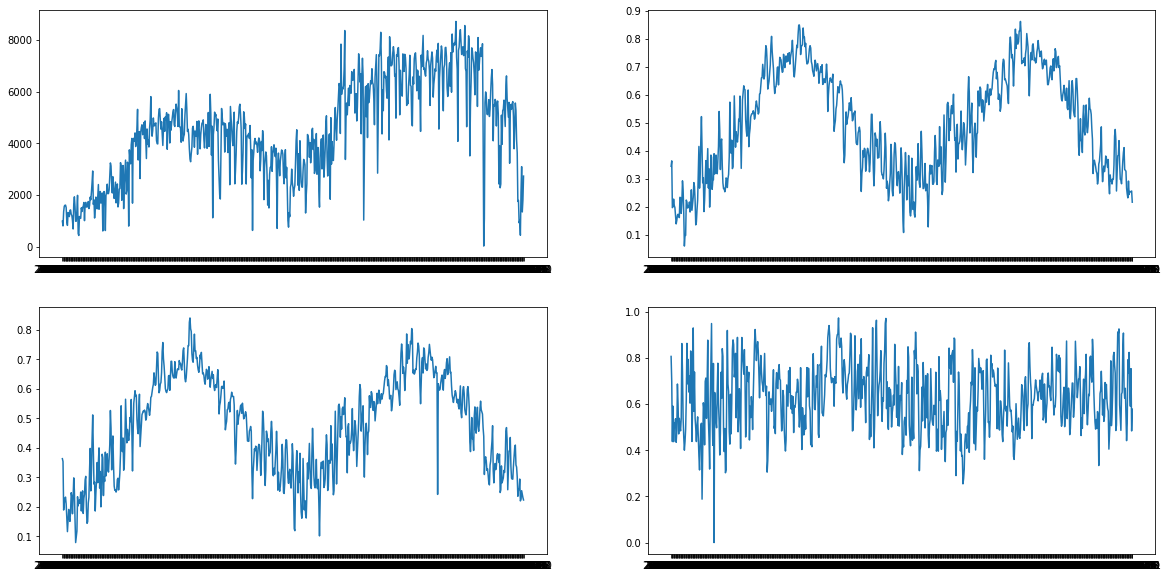

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(daily_raw_data['dteday'],daily_raw_data['cnt'])
plt.subplot(2, 2, 2)
plt.plot(daily_raw_data['dteday'],daily_raw_data['temp'])
plt.subplot(2, 2, 3)
plt.plot(daily_raw_data['dteday'],daily_raw_data['atemp'])
plt.subplot(2, 2, 4)
plt.plot(daily_raw_data['dteday'],daily_raw_data['hum'])

### HOURLY DATA visuals

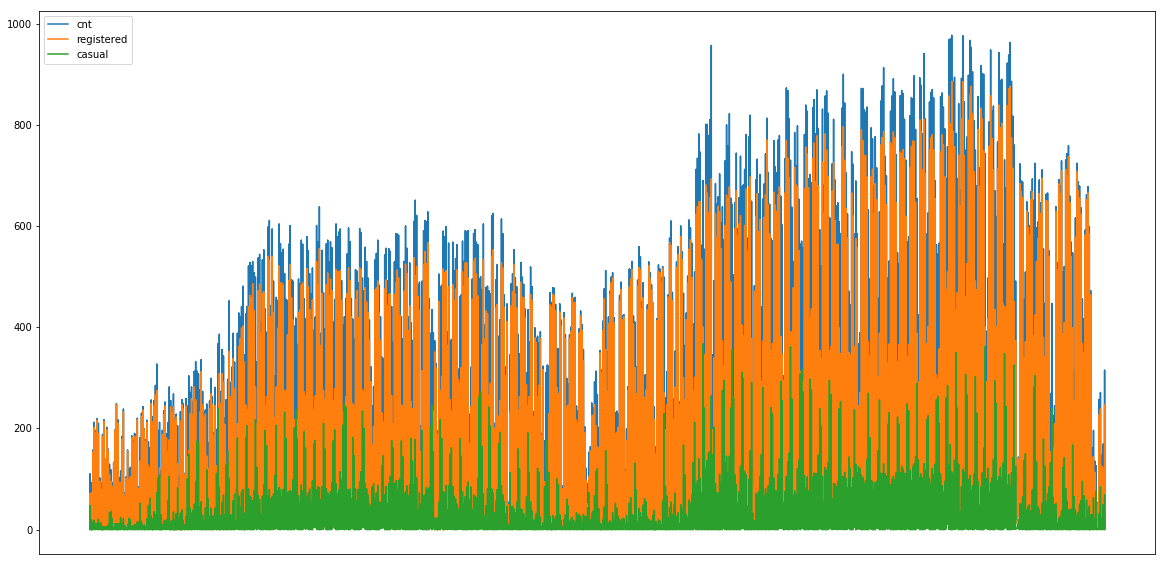

In [17]:

import matplotlib.dates as mdates

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

plt.figure(figsize=(20,10))
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['cnt'])
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['registered'])
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['casual'])
plt.legend(['cnt', 'registered', 'casual'], loc='upper left')

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

plt.show()

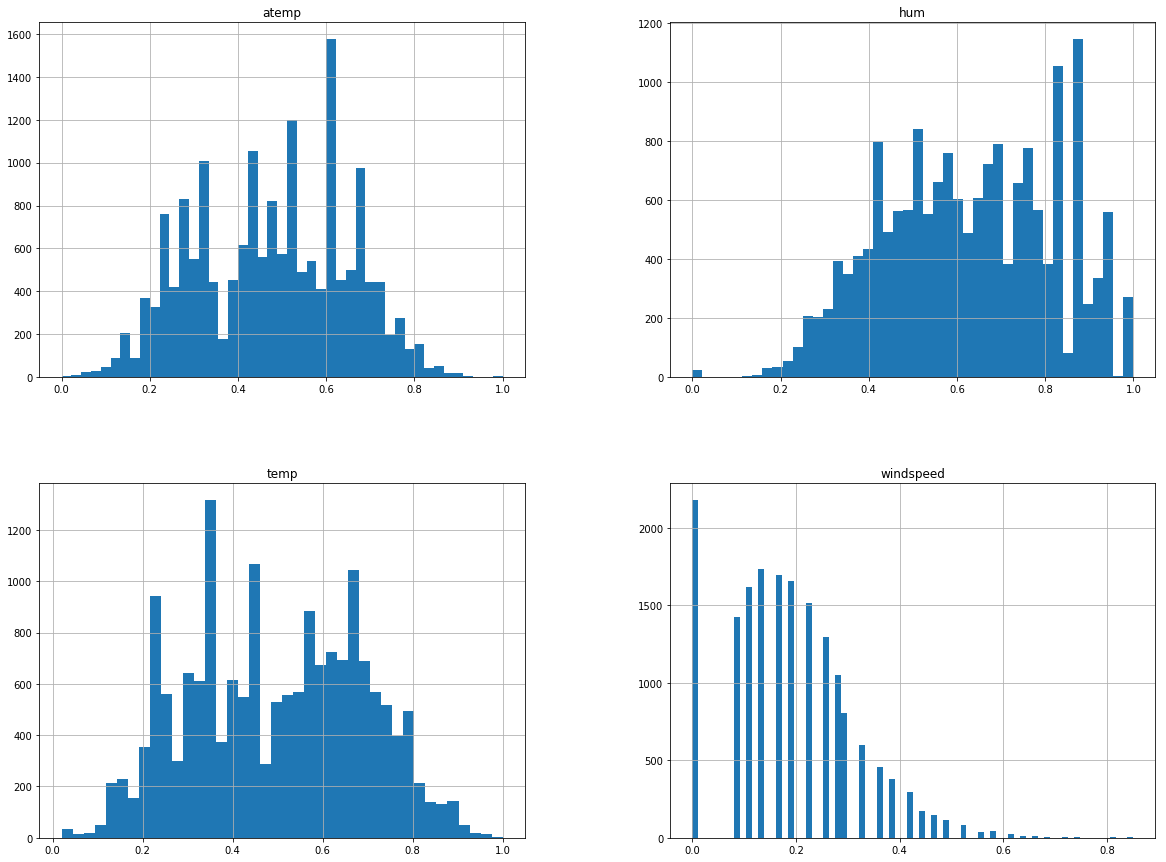

In [18]:

num_bins = 'auto'
to_hist = ['atemp','temp','hum','windspeed']
hourly_raw_data[to_hist].hist(bins=num_bins, figsize=(20, 15))

plt.show()

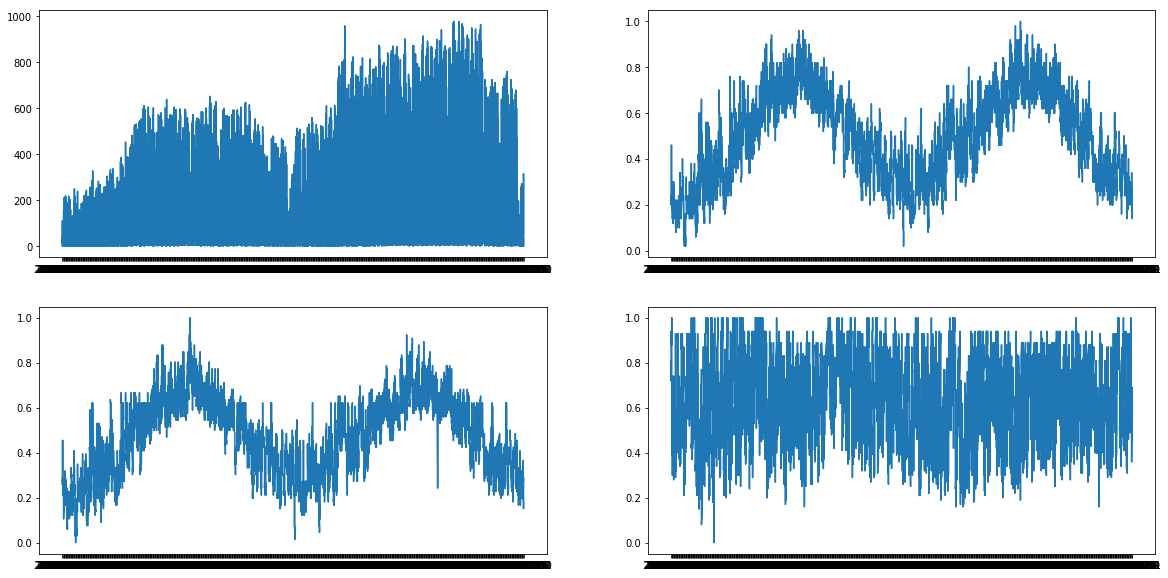

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(2,2, 1)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['cnt'])
plt.subplot(2, 2, 2)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['temp'])
plt.subplot(2, 2, 3)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['atemp'])
plt.subplot(2, 2, 4)
plt.plot(hourly_raw_data['dteday'],hourly_raw_data['hum'])

### Correlation Matrix

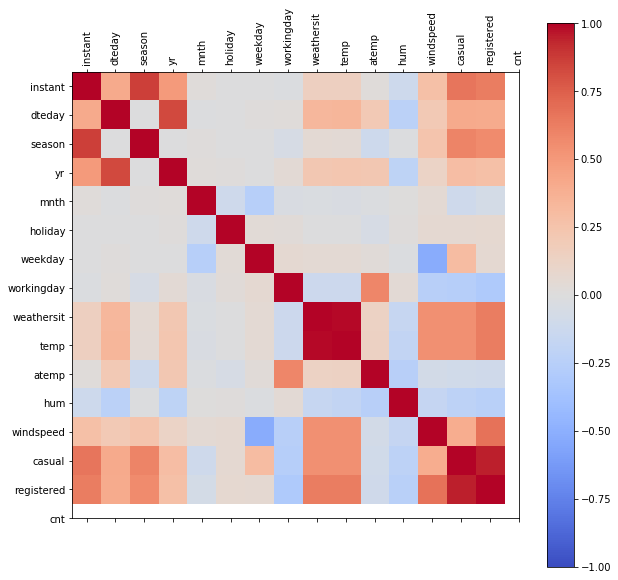

In [20]:
#Daily
plt.rcParams["figure.figsize"] = (10,10)
corr = daily_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily_raw_data.columns)
ax.set_yticklabels(daily_raw_data.columns)
plt.show()

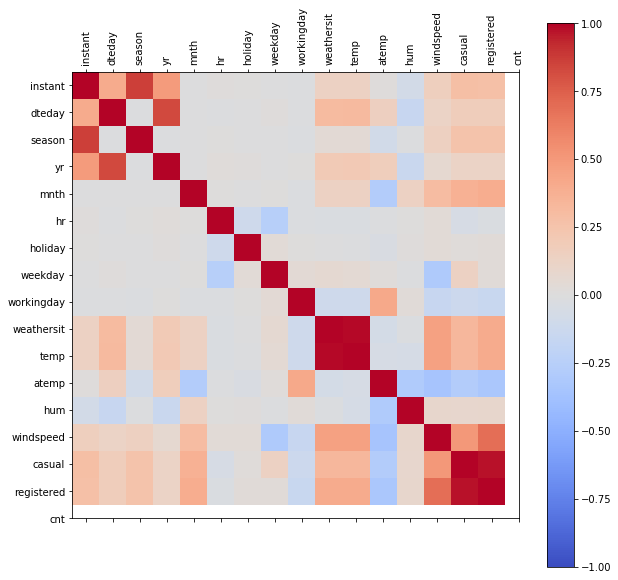

In [21]:
#Hourly
plt.rcParams["figure.figsize"] = (10,10)
corr = hourly_raw_data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly_raw_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly_raw_data.columns)
ax.set_yticklabels(hourly_raw_data.columns)
plt.show()

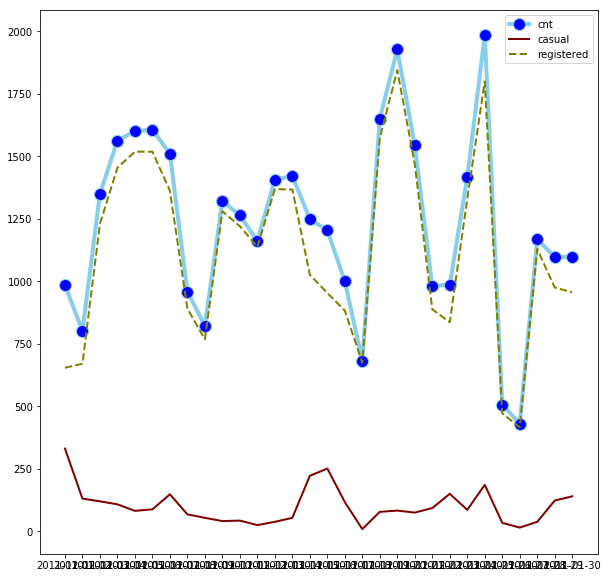

In [22]:
# sns.lineplot(x="dteday", y="cnt", hue="casual", data=hourly_raw_data[:100])
df = daily_raw_data[:30].copy()
df.set_index(df.dteday)
# sns.tsplot(df.cnt)
plt.plot( 'dteday', 'cnt', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'dteday', 'casual', data=df, marker='', color='maroon', linewidth=2)
plt.plot( 'dteday', 'registered', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.legend()
plt.show()

### EDA after spliting

[Text(0.5, 1.0, 'Season wise hourly distribution of counts')]

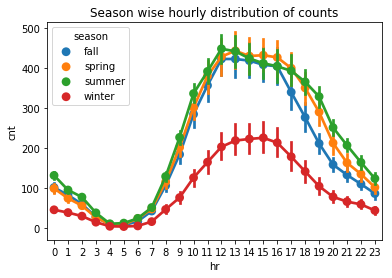

In [46]:
fig,ax = plt.subplots()
sns.pointplot(data=we_hr[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of counts for weekdays")
plt.show()

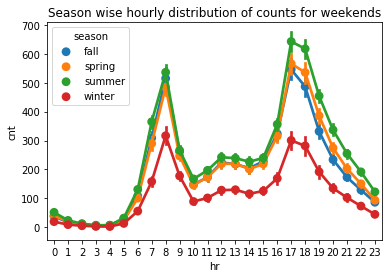

In [50]:
fig,ax = plt.subplots()
sns.pointplot(data=wd_hr[['hr',
                           'cnt',
                           'season']],
              x='hr',
              y='cnt',
              hue='season',
              ax=ax)
ax.set(title="Season wise hourly distribution of counts for weekends")
plt.show()

# Data transformation

### Converting `dteday` to date

In [5]:
daily_raw_data['dteday']=pd.to_datetime(daily_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday']=pd.to_datetime(hourly_raw_data['dteday'], format='%Y-%m-%d')
hourly_raw_data['dteday'].head()

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: dteday, dtype: datetime64[ns]

## Add `isDaylight` and  `isNoon` for hourly data

In [36]:
hourly_raw_data['isDaylight']=0
hourly_raw_data['isNoon']=0

hourly_raw_data = hourly_raw_data.apply(lambda x: isDaylight(x), axis=1)
hourly_raw_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,isDaylight,isNoon
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,0,0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,0,0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,0,0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,0,0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,0


### Check (and fix?) skewness

In [7]:
check_skewness(hourly_raw_data, ['atemp','temp','hum','windspeed'])

atemp skewness p-value : -0.09042105336080838
temp skewness p-value : -0.00602036366695605
hum skewness p-value : -0.1112775438226877
windspeed skewness p-value : 0.5748555816221624

------

skewed_features:
[]


### Adding the temp atemp windspeed hum relative to the last 7 days value

In [52]:
to_relative  = ['temp', 'atemp', 'hum','windspeed']
hourly_raw_data = relative_values(hourly_raw_data, to_relative)

### Spliting weekends weekdays and arranging the names

In [53]:
wd_hr = num_name(hourly_raw_data.loc[(~hourly_raw_data['weekday'].isin([0,6]) )])
we_hr = num_name(hourly_raw_data.loc[(hourly_raw_data['weekday'].isin([0,6]) )])

In [54]:
wd_hr 

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,atemp,hum,windspeed,casual,registered,cnt,relative_temp,relative_atemp,relative_hum,relative_windspeed
47,48,2011-01-03,winter,0,1,0,0,1,1,Good,...,0.1970,0.44,0.3582,0,5,5,-1.611902,-2.187736,-2.120149,1.319830
48,49,2011-01-03,winter,0,1,1,0,1,1,Good,...,0.1667,0.44,0.4179,0,2,2,-1.790420,-2.457331,-2.004706,1.788473
49,50,2011-01-03,winter,0,1,4,0,1,1,Good,...,0.1364,0.47,0.3881,0,1,1,-2.180605,-2.668431,-1.715317,1.467279
50,51,2011-01-03,winter,0,1,5,0,1,1,Good,...,0.1364,0.47,0.2836,0,3,3,-2.061394,-2.468796,-1.649606,0.565362
51,52,2011-01-03,winter,0,1,6,0,1,1,Good,...,0.1061,0.50,0.3881,0,30,30,-2.177167,-2.646587,-1.406539,1.420623
52,53,2011-01-03,winter,0,1,7,0,1,1,Good,...,0.1364,0.50,0.1940,1,63,64,-2.062780,-2.137702,-1.366946,-0.206745
53,54,2011-01-03,winter,0,1,8,0,1,1,Good,...,0.1212,0.50,0.2836,1,153,154,-1.964770,-2.186053,-1.330536,0.534626
54,55,2011-01-03,winter,0,1,9,0,1,1,Good,...,0.1364,0.43,0.3881,7,81,88,-1.680945,-1.924116,-1.716981,1.396555
55,56,2011-01-03,winter,0,1,10,0,1,1,Good,...,0.1667,0.43,0.2537,11,33,44,-1.428482,-1.551822,-1.656949,0.252381
56,57,2011-01-03,winter,0,1,11,0,1,1,Good,...,0.1818,0.40,0.3284,10,41,51,-1.196660,-1.361382,-1.777117,0.870775


### One hot Encoding
For `season`, `weathersit`, `mnth`,`weekday`,`hr`

In [45]:
category  = ['season', 'weathersit', 'mnth','weekday','hr']

wd_h = onehot_encode(wd_hr,category)
wd_h  = wd_h.drop('instant',axis=1)

we_h = onehot_encode(we_hr,category)
we_h  = we_h.drop('instant',axis=1)

In [18]:
to_relative  = ['temp', 'atemp', 'hum','windspeed']
hourly = relative_values(hourly, to_relative)

### Genetic Programming

In [165]:
### Adding genetically programmed features to the data set 
## *** make sure to use the right target ... will start with cnt for now and will drop casual***
t_hourly = Genetic_P(hourly.drop(['registered','casual','dteday'],axis=1),'cnt')

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.13 0.08778209052574792       10 0.49892555056819776 0.5085881765868786      1.69m
   1     6.59 0.28057999150188595       12 0.6028509408073798 0.615472667877619      1.54m
   2     5.26 0.42440467591838904       12 0.6125676084747488 0.6247394441872826      1.45m
   3     7.83 0.44242670170391407       15 0.6513580447073263 0.6389678505607975      1.37m
   4    11.63 0.5124653016556951       19 0.6836654044386885 0.6782805950135526      1.30m
   5     14.7 0.5457222577468959       19 0.6840727177704434 0.6741204222552305      1.22m
   6    19.09 0.5724980531971047       52 0.7065516514989636 0.7086366540939636      1.16m
   7    24.73 0.6020096061768975       29 0.7157089218248321 0.7126907154158522      1.11m
   8    31.31 0.6203453

ADDING THE DATE AGAIN TO BE ABLE TO SEPARATE

In [166]:
hourly = pd.concat([pd.DataFrame(t_hourly ),pd.DataFrame(hourly['dteday'])],axis=1 ,join = 'inner') 

In [40]:
we_h = Genetic_P(we_h.drop(['registered','casual','dteday'],axis=1),'cnt')
wd_h = Genetic_P(wd_h.drop(['registered','casual','dteday'],axis=1),'cnt')

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.12 0.11712804152032621       11 0.6787411613213609 0.700458547284513     25.30s
   1     6.35 0.35845399209346224        3 0.6838894649903093 0.6571276282310623     44.85s
   2     5.45 0.5256059328060493        7 0.7196750209642792 0.713216436454625     52.71s
   3     6.06 0.5996199193092033       16 0.726831609546721 0.7224981765667348     59.11s
   4     8.23 0.6012401072008381       20 0.7450522435183171 0.7510663237839207     57.07s
   5    10.64 0.5888332591395615       24 0.76078982524115 0.7922734226142008     55.27s
   6    13.46 0.5994116179477994       25 0.7805150276986715 0.7894184939813786     53.03s
   7    20.69 0.6008568461697236       59 0.7970104135400262 0.8039388801399046     50.58s
   8    26.74 0.61995611497327

In [51]:
dd = hourly_raw_data.loc[(~hourly_raw_data['weekday'].isin([0,6]) )]['dteday']
de = hourly_raw_data.loc[(hourly_raw_data['weekday'].isin([0,6]) )]['dteday']
we_h = pd.concat([pd.DataFrame(we_h ),pd.DataFrame(de)],axis=1 ,join = 'inner') 
wd_h = pd.concat([pd.DataFrame(wd_h ),pd.DataFrame(dd)],axis=1 ,join = 'inner') 

In [33]:
# Test
regr = LinearRegression(fit_intercept =True)
regr.fit(X1_Train, y_reg_train)
y_pred = regr.predict(X1_Test)
r2_score(y_cnt_test,y_cas_test + y_pred)
##regr.score(X2_Test, y_cnt_test)

NameError: name 'X1_Train' is not defined

### Correlation Matrix (After hot encoding)

In [ ]:
# Daily
plt.rcParams["figure.figsize"] = (12,8)
corr = daily.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(daily.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(daily.columns)
ax.set_yticklabels(daily.columns)
plt.show()

In [ ]:
#Hourly
plt.rcParams["figure.figsize"] = (12,8)
corr = hourly.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(hourly.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(hourly.columns)
ax.set_yticklabels(hourly.columns)
plt.show()

# Modeling (Baseline)

## Spliting train test

In [52]:
xwe_Train = we_h[we_h['dteday'] < '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THst_EM IN DATA
xwe_Test = we_h[we_h['dteday'] >= '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THEM IN DATA
ywe_cnt_test =we_h['cnt'][we_h['dteday'] >= '2012-10-01']
ywe_cnt_train =we_h['cnt'][we_h['dteday'] < '2012-10-01']

xwd_Train = wd_h[wd_h['dteday'] < '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THst_EM IN DATA
xwd_Test = wd_h[wd_h['dteday'] >= '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THEM IN DATA
ywd_cnt_test =wd_h['cnt'][wd_h['dteday'] >= '2012-10-01']
ywd_cnt_train =wd_h['cnt'][wd_h['dteday'] < '2012-10-01']

In [ ]:
# X_Train = hourly[hourly['dteday'] < '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THst_EM IN DATA
# X_Test = hourly[hourly['dteday'] >= '2012-10-01'].drop(['cnt','dteday'],axis=1)## NONE OF THEM IN DATA
# Y_cnt_test =hourly['cnt'][hourly['dteday'] >= '2012-10-01']
# Y_cnt_train =hourly['cnt'][hourly['dteday'] < '2012-10-01']

In [ ]:
# Create linear regression object
regr = LinearRegression(fit_intercept =True)
regr.fit(X2_Train, y_cas_train)
y_pred = regr.predict(X2_Test)
r2_score(y_cnt_test,y_reg_test + y_pred)
##regr.score(X2_Test, y_cnt_test)

In [ ]:
params = pd.Series(regr.coef_, index=X2_Train.columns)

Linear Models

In [ ]:
##Linear Regression
lm_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True]}
tscv = TimeSeriesSplit(n_splits=5)
lm = GridSearchCV(LinearRegression(),
                                 param_grid=lm_parameters,
                                 cv=tscv,return_train_score=True)

lm.fit(X_Train, Y_cnt_train)
lm.cv_results_
lm.score(X_Test, Y_cnt_test)

In [ ]:
##OrthogonalMatchingPursuit
omp_parameters = {'n_nonzero_coefs':[5,10,15],'fit_intercept':[True,False], 'normalize':[True,False]}
tscv = TimeSeriesSplit(n_splits=5)
omp = GridSearchCV(OrthogonalMatchingPursuit(),
                                 param_grid=omp_parameters,
                                 cv=tscv,return_train_score=True)

omp.fit(X_Train, Y_cnt_train)
omp.cv_results_
omp.score(X_Test, Y_cnt_test)

Random Forest Model

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
RF_parameters = {'n_estimators': [10, 30 ,100],
                                             'bootstrap': [True],
                                             'max_depth': [80, 100  ],
                                             'max_features': ['sqrt',16],
                                             'min_samples_leaf': [2,  5 , 8],
                                             'min_samples_split': [ 10 , 8 , 15],
                                            'random_state':[random_seed],
                                            'criterion':['mse']}
rf = GridSearchCV(RandomForestRegressor(),
                                 param_grid= RF_parameters,
                                 cv=tscv)
rf.fit(X_Train, Y_cnt_train)
rf.cv_results_
rf.score(X_Test, Y_cnt_test)

K- Nearest Neighbors

In [ ]:
knn_parameters = {'n_neighbors':[5,10,15],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[20,30],
                  'p':[1,2],'metric':['minkowski']}
tscv = TimeSeriesSplit(n_splits=5)
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)

knn.fit(xwe_Train, ywe_cnt_train)
ywe_pred = knn.predict(xwe_Test)
print(r2_score(ywe_cnt_test, ywe_pred))

In [ ]:
knn_parameters = {'n_neighbors':[5,10,15],'weights':['uniform'], 'algorithm':['auto'],'leaf_size':[20,30],
                  'p':[1,2],'metric':['minkowski']}
tscv = TimeSeriesSplit(n_splits=5)
knn = GridSearchCV(KNeighborsRegressor(),
                                 param_grid=knn_parameters,
                                 cv=tscv,return_train_score=True)

rf.fit(xwd_Train, ywd_cnt_train)
ywe_pred = rf.predict(xwd_Test)
print(r2_score(ywd_cnt_test, ywd_pred))

In [ ]:
ywd_pred = rf.predict(xwd_Test)
print(r2_score(ywd_cnt_test, ywd_pred))